In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
# import tensorflow.compat.v1 as tf1
from tensorflow.keras import activations
tf.compat.v1.disable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2022-11-28 01:15:02.908292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from cust_rnn import BasicRNNCell

In [4]:
n_windows = 200
n_input =  1
n_output = 1
size_train = 2001
r_neuron = 120   

In [5]:
def create_ts(start = '2001', n = 201, freq = 'M'):
    rng = pd.date_range(start=start, periods=n, freq=freq)
    ts = pd.Series(np.random.uniform(-18, 18, size=len(rng)), rng).cumsum()
    return ts
ts = create_ts(start = '2001', n = 2205)

In [6]:
series = np.array(ts[3:])
train = series[:size_train]
test = series[size_train:]
print(train.shape, test.shape)

(2001,) (201,)


In [7]:
x_data = train[:size_train-1]
X_batches = x_data.reshape(-1, n_windows, n_input)
def create_batches(df, windows, input, output):
    ## Create X         
        x_data = train[:size_train-1] # Select the data
        X_batches = x_data.reshape(-1, windows, input)  # Reshape the data 
    ## Create y
        y_data = train[n_output:size_train]
        y_batches = y_data.reshape(-1, windows, output)
        return X_batches, y_batches

In [8]:
X_batches, y_batches = create_batches(df = train,
                                      windows = n_windows,
                                      input = n_input,
                                      output = n_output)
print(X_batches.shape, y_batches.shape)

(10, 200, 1) (10, 200, 1)


In [9]:
X_test, y_test = create_batches(df = test, windows = 200,input = 1, output = 1)
print(X_test.shape, y_test.shape)

(10, 200, 1) (10, 200, 1)


In [10]:
params = {"l2scale":4e-6,
        "alpha_resample_ratio":0.9,
        "transition_std":[10,3,5],
        "time_step":1.0,
        "decayrate":0.5,
        "learningrate":0.0001,
        "num_particles":100,
        }

In [11]:
batch_num = 10
particle_states_inits = np.zeros((batch_num,params["num_particles"], 3)) 
for i in range(0,batch_num):
    ri = np.zeros((params["num_particles"], 3))
    tsi = x_data[i*n_windows:i*n_windows + 3]
    # r = [tsi[2],  (tsi[2] - tsi[1]) / params['time_step'], ((tsi[2] - tsi[1]) - (tsi[1] - tsi[0])) / params['time_step']]

    #some cheating
    inc_data = x_data[i*n_windows:(i+1)*n_windows]
    v = [i-j for i,j in zip(inc_data[1:], inc_data[:-1])]
    a = [i-j for i,j in zip(v[1:], v[:-1])]
    r = [tsi[2],  np.average(v), np.average(a)]

    for ridx in range(0,3):
        ri[:,ridx] = np.random.uniform(r[ridx] - params['transition_std'][ridx], r[ridx] + params['transition_std'][ridx], (params["num_particles"]))
    particle_states_inits[i] = ri


In [12]:
fv = np.log(1.0/float(params['num_particles']))
particle_weights_inits = np.full(shape=particle_states_inits.shape[:-1], fill_value=fv)

In [13]:
lag_len = 5
last_window_points = np.array([x_data[i-lag_len:i] if i>=lag_len else np.concatenate((np.zeros(lag_len-i),x_data[:i])) for i in range(0,len(x_data))]).reshape(batch_num, n_windows, -1)

In [14]:
from cust_rnn import PFNET

In [15]:
batches_to_include = 2
points_to_include = 15
fl = [X_batches[:batches_to_include,:points_to_include], particle_states_inits[:batches_to_include], particle_weights_inits[:batches_to_include], last_window_points[:batches_to_include,:points_to_include], y_batches[:batches_to_include, :points_to_include]]

In [16]:
train_brain = PFNET(params, [fl[1].shape, fl[0].shape, fl[3].shape], fl[4].shape, True)

2022-11-28 01:15:10.208426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:

init_op = tf.group(tf.compat.v1.global_variables_initializer(), tf.compat.v1.local_variables_initializer())
iteration = 20
with tf.compat.v1.Session() as sess:
    sess.run(init_op)
    print("done with run init") #11
    # obs_in, init_particle_states, init_particle_weights, prev_window, true_pos
    
    fd = {i:fl[idx] for idx, i in enumerate(train_brain.inputs)}
    print("done with fd") #0
    for iters in range(iteration):
        _, loss, _, o= sess.run([train_brain.train_op, train_brain.train_loss_op,
                                               train_brain.update_state_op, train_brain.print_state_op], feed_dict=fd)
        print(loss)
    print("done with op") #4

2022-11-28 01:15:10.879713: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


done with run init
done with fd
26713.352
82986.836
165810.66
23409.904
90311.83
233717.03
10204.533
34360.242
138251.66
9732.21
54497.715
118216.234
96723.21
68971.94
269213.7
21951.906
141889.86
39480.055
208340.83
170513.0
done with op


In [18]:
x_data[0]

0.6724779023079037

In [19]:
np.ptp(particle_states_inits[0][:,0]), np.mean(particle_states_inits[0][:,0])

(19.64545965110088, 27.280536038667172)

In [20]:
iter_idx = 2
test_states = o[0][0][iter_idx]
test_weights = o[1][0][iter_idx]
test_states.shape, test_weights.shape

((100, 3), (100,))

In [21]:
test_weights

array([-0.00028229,  0.00037003, -0.00076485,  0.00037003, -0.00076485,
        0.00037003, -0.00076485, -0.00028229,  0.00037003, -0.00076485,
       -0.00076485,  0.00037003,  0.00016928,  0.00037003, -0.00076485,
       -0.00076485, -0.00076485, -0.00076485, -0.00076485,  0.00037003,
       -0.00028229,  0.00037003, -0.00076485,  0.00037003,  0.00037003,
       -0.00028229,  0.00016928,  0.00037003,  0.00016928,  0.00037003,
        0.00037003, -0.00076485, -0.00076485,  0.00037003,  0.00037003,
        0.00037003, -0.00076485, -0.00076485, -0.00076485,  0.00016928,
        0.00037003, -0.00076485,  0.00037003, -0.00076485,  0.00016928,
        0.00037003,  0.00016928,  0.00037003, -0.00076485, -0.00028229,
        0.00037003, -0.00076485,  0.00016928, -0.00076485, -0.00076485,
       -0.00076485,  0.00037003, -0.00076485, -0.00028229,  0.00016928,
        0.00037003, -0.00076485,  0.00016928,  0.00016928,  0.00016928,
        0.00037003, -0.00076485, -0.00076485,  0.00037003,  0.00

In [22]:
test_states

array([[ 38.04035   ,  -4.585389  , -14.495344  ],
       [ 16.080105  ,   4.6998906 ,   1.5606755 ],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 16.080105  ,   4.6998906 ,   1.5606755 ],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 16.080105  ,   4.6998906 ,   1.5606755 ],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 38.04035   ,  -4.585389  , -14.495344  ],
       [ 16.080105  ,   4.6998906 ,   1.5606755 ],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 16.080105  ,   4.6998906 ,   1.5606755 ],
       [ 26.051208  ,  10.809425  ,   7.22068   ],
       [ 16.080105  ,   4.6998906 ,   1.5606755 ],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 54.835957  ,   5.517268  ,  -0.91186476],
       [ 16.080105  ,   4.69989

In [23]:
# test weights loved state sample 5, with value -8.568, velocity -14, acc -24
# i assume this sent all the weights into a massive downwards spiral

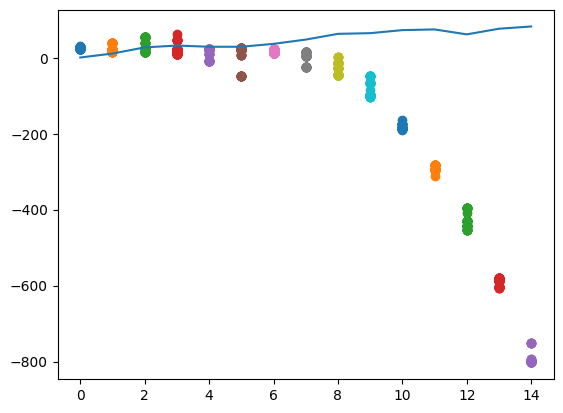

In [24]:
points_to_plot = points_to_include
states_over_time = o[0][0][:,:,0]
plt.plot(X_batches[0][:points_to_plot])
for idx, s in enumerate(states_over_time[:points_to_plot]):
    plt.scatter([idx] * len(s), s)

In [26]:
X = tf.keras.Input(dtype = tf.float32, shape = (n_windows, n_input), batch_size=10)
y = tf.keras.Input(dtype = tf.float32, shape = (n_windows, n_output), batch_size=10)
# X = tf.placeholder(tf.float32, [None, n_windows, n_input])   
# y = tf.placeholder(tf.float32, [None, n_windows, n_output])

basic_cell = BasicRNNCell(r_neuron, activation=tf.nn.relu) 
# basic_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(r_neuron, activation=tf.nn.relu) 

# rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)              
rnn_output, states = tf.keras.layers.RNN(cell = basic_cell, dtype = tf.float32, return_sequences=True, return_state=True)(inputs = X)
stacked_rnn_output = tf.reshape(rnn_output, [-1, r_neuron])          
stacked_outputs = tf.keras.layers.Dense(n_output)(stacked_rnn_output)
outputs = tf.reshape(stacked_outputs, [-1, n_windows, n_output])

build called
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2022-11-28 01:15:43.595829: W tensorflow/c/c_api.cc:291] Operation '{name:'basic_rnn_cell/bias/Assign' id:3841 op device:{requested: '', assigned: ''} def:{{{node basic_rnn_cell/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](basic_rnn_cell/bias, basic_rnn_cell/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [29]:
learning_rate = 0.001  
 
loss = tf.reduce_sum(tf.square(outputs - y))    
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss) 

In [30]:
init = tf.compat.v1.global_variables_initializer() 
iteration = 1500 

with tf.compat.v1.Session() as sess:
    init.run()
    for iters in range(iteration):
        sess.run(training_op, feed_dict={X: X_batches, y: y_batches})
        if iters % 150 == 0:
            mse = loss.eval(feed_dict={X: X_batches, y: y_batches})
            print(iters, "\tMSE:", mse)
    
    y_pred = sess.run(outputs, feed_dict={X: X_test})

0 	MSE: 132830424.0
150 	MSE: 638157.3
300 	MSE: 382417.94
450 	MSE: 231434.75
600 	MSE: 200921.19
750 	MSE: 194064.5
900 	MSE: 188443.75
1050 	MSE: 183559.31
1200 	MSE: 182908.45
1350 	MSE: 176724.03


/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_44421/2606641324.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
/var/folders/1_/_n_tsfn5339_d17486wc50nw0000gn/T/ipykernel_44421/2606641324.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')


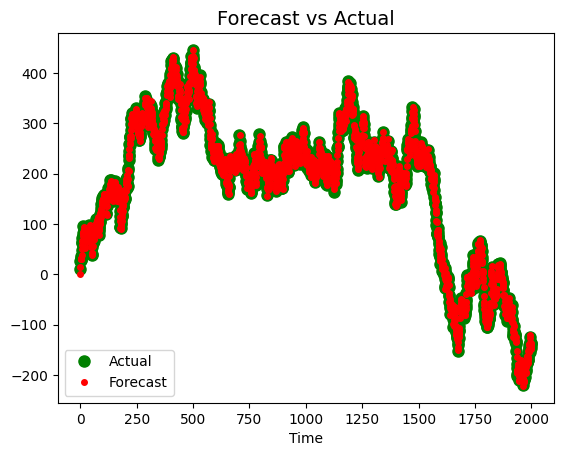

In [31]:
plt.title("Forecast vs Actual", fontsize=14)
plt.plot(pd.Series(np.ravel(y_test)), "bo", markersize=8, label="Actual", color='green')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=8, label="Forecast", color='red')
plt.legend(loc="lower left")
plt.xlabel("Time")

plt.show()